In [1]:
# pip install the OpenCV version from 'contrib'
!pip install opencv-contrib-python==3.4.2.17

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 30.6 MB 1.3 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.6.0.66
    Uninstalling opencv-contrib-python-4.6.0.66:
      Successfully uninstalled opencv-contrib-python-4.6.0.66


In [2]:
# import packages here
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
print(cv2.__version__) # verify OpenCV version
import os
from google.colab.patches import cv2_imshow

3.4.2


In [3]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%cd '/content/gdrive/My Drive/CVHomework1/'

/content/gdrive/My Drive/CVHomework1


## Problem 1: Match transformed images using SIFT features
{40 points + bonus 5} You will transform a given image, and match it back to the original image using SIFT keypoints. 

- **Step 1 (5pt)**. Use the function from SIFT class to detect keypoints from the given image. Plot the image with keypoints scale and orientation overlaid.

- **Step 2 (10pt)**. Rotate your image clockwise by 60 degrees with the `cv2.warpAffine` function. Extract SIFT keypoints for this rotated image and plot the rotated picture with keypoints scale and orientation overlaid just as in step 1.

- **Step 3 (15pt)**. Match the SIFT keypoints of the original image and the rotated imag using the `knnMatch` function in the `cv2.BFMatcher` class. Discard bad matches using the ratio test proposed by D.Lowe in the SIFT paper. Use **0.1** as the ratio in this homework. Note that this is for display purpose only. Draw the filtered good keypoint matches on the image and display it. The image you draw should have two images side by side with matching lines across them.

- **Step 4 (10pt)**. Use the RANSAC algorithm to find the affine transformation from the rotated image to the original image. You are not required to implement the RANSAC algorithm yourself, instead you could use the `cv2.findHomography` function (set the 3rd parameter `method` to `cv2.RANSAC`) to compute the transformation matrix. Transform the rotated image back using this matrix and the `cv2.warpPerspective` function. Display the recovered image.

- **Bonus (5pt)**. You might have noticed that the rotated image from step 2 is cropped. Rotate the image without any cropping and you will be awarded an extra 5 points.

Hints: In case of too many matches in the output image, use the ratio of 0.1 to filter matches.

The image is a duplicate of *The Yellow House (The Street)* by Vincent van Gogh. See https://www.vangoghmuseum.nl/en/collection/s0032V1962 for more information about this work.


In [5]:
def rotation_without_cropping(rotation_matrix, row,col):
  # The input image when rotated gets cropped. To avoid cropping, we need to do two things
  # 1. Increase height and width of the new image ( w = hsin(theta) + wcos(theta), h = hcos(theta) + wsin(theta))
  sin_theta = abs(rotation_matrix[0,1])
  cos_theta = abs(rotation_matrix[0,0])
  col_new = int(row * sin_theta + col * cos_theta)
  row_new = int(row * cos_theta + col * sin_theta)

  # 2. Now the width has been increased but the image is still not centered. To make that happen,
  #  we need to translate the new image to the new center(height/2,width/2). Let's add the difference to rotation matrix to translate
  rotation_matrix[0,2] += (col_new//2 - col//2)
  rotation_matrix[1,2] += (row_new//2 - row//2) 

  return rotation_matrix, row_new, col_new


def drawMatches(img1, kp1, img2, kp2, matches):
    """
    My own implementation of cv2.drawMatches as OpenCV 2.4.9
    does not have this function available but it's supported in
    OpenCV 3.0.0

    This function takes in two images with their associated 
    keypoints, as well as a list of DMatch data structure (matches) 
    that contains which keypoints matched in which images.

    An image will be produced where a montage is shown with
    the first image followed by the second image beside it.

    Keypoints are delineated with circles, while lines are connected
    between matching keypoints.

    img1,img2 - Grayscale or Color images
    kp1,kp2 - Detected list of keypoints through any of the OpenCV keypoint 
              detection algorithms
    matches - A list of matches of corresponding keypoints through any
              OpenCV keypoint matching algorithm
    """

    # Create a new output image that concatenates the two images together
    # (a.k.a) a montage
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    # Create the output image
    # The rows of the output are the largest between the two images
    # and the columns are simply the sum of the two together
    # The intent is to make this a colour image, so make this 3 channels
    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')

    # Place the first image to the left
    # stack if the inputs are gray images
    if len(img1.shape) == 2:
      img1 = np.dstack([img1, img1, img1])
    if len(img2.shape) == 2:
      img2 = np.dstack([img2, img2, img2]) 
 
    out[:rows1, :cols1, :] = img1

    # Place the next image to the right of it
    out[:rows2, cols1:, :] = img2

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mat in matches:
        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns
        # y - rows
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt

        # Draw a small circle at both co-ordinates
        # radius 4
        # colour blue
        # thickness = 1
        cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1)   
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1)

        # Draw a line in between the two points
        # thickness = 1
        # colour blue
        cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (0,255,0), 2)
    # Also return the image if you'd like a copy
    return out

# Read image
img_input = cv2.imread('/content/gdrive/MyDrive/CVHomework2/SourceImages/vangogh_yellow_house.jpg',0)
#print(img_input.dtype)
image = img_input.astype('uint8')

# initiating the SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp, des = sift.detectAndCompute(img_input, None)

# Draw keypoints on the image
# use cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS flag
res1 = cv2.drawKeypoints(img_input, kp, None, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# rotate image
# to rotate image, i created the following Rotation Matrix R
row_img, col_img = img_input.shape[:2]
my_rotation_matrix = cv2.getRotationMatrix2D((col_img//2,row_img//2),315,1)

# use cv2.warpAffine to rotate image
my_rotation_matrix, row__img_new, col_img_new = rotation_without_cropping(my_rotation_matrix, row_img, col_img)
img_input_rot = cv2.warpAffine(img_input,my_rotation_matrix,(col_img_new,row__img_new))

# find the keypoints and descriptors on the rotated image
sift_rot = cv2.xfeatures2d.SIFT_create()
kp_rot, des_rot = sift_rot.detectAndCompute(img_input_rot, None)

# Draw keypoints on the rotated image
# use cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS flag
res2 = cv2.drawKeypoints(img_input_rot, kp_rot, None, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS )

# Plot result images
plt.figure(figsize=(14,8))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(res1, cv2.COLOR_BGR2RGB));
plt.title('original img')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(res2, cv2.COLOR_BGR2RGB));
plt.title('rotated img')
plt.axis('off')

# compute feature matching
# use the knnMatch function in the cv2.BFMatcher class
my_bf = cv2.BFMatcher()
my_matches = my_bf.knnMatch(des, des_rot , k = 2)

# Apply ratio test to keep good matches; ratio=0.1
my_good_matches = []
for m, n in my_matches :
  if m.distance < 0.1*n.distance :
    my_good_matches.append(m)

# draw matching results with the given drawMatches function
res3 = drawMatches(img_input, kp, img_input_rot, kp_rot, my_good_matches)

plt.figure(figsize=(14,8))
plt.imshow(cv2.cvtColor(res3, cv2.COLOR_BGR2RGB));
plt.title('matching')
plt.axis('off')

# find perspective transform matrix using RANSAC
# use cv2.findHomography
my_dest_points = np.float32([kp[m.queryIdx].pt for m in my_good_matches]).reshape(-1, 1, 2)
my_source_points = np.float32([kp_rot[m.trainIdx].pt for m in my_good_matches]).reshape(-1, 1, 2)
my_transform_matrix, retval =  cv2.findHomography(my_source_points, my_dest_points, cv2.RANSAC)

# mapping rotataed image back with the calculated rotation matrix
# use cv2.warpPerspective


res4 = cv2.warpPerspective(img_input_rot, my_transform_matrix, (col_img,row_img))
res4 = res4.astype('uint8')

# plot result images
plt.figure(figsize=(14,8));
plt.subplot(1, 2, 1);
plt.imshow(cv2.cvtColor(res1, cv2.COLOR_BGR2RGB));
plt.title('original img');
plt.axis('off');

plt.subplot(1, 2, 2);
plt.imshow(cv2.cvtColor(res4, cv2.COLOR_GRAY2RGB));
plt.title('recovered img');
plt.axis('off');


AttributeError: ignored

## Problem 2: Scene stitching with SIFT features
{30 points + 20 bonus} You will match and align between different views of a scene with SIFT features. 

Use `cv2.copyMakeBorder` function to pad the center image with zeros into a larger size. Extract SIFT features for all images and go through the same procedures as you did in problem 1. Your goal is to find the affine transformation between the two images and then align one of your images to the other using `cv2.warpPerspective`. Use the `cv2.addWeighted` function (or your own implementation) to blend the aligned images and show the stitched result. Examples can be found at http://docs.opencv.org/trunk/d0/d86/tutorial_py_image_arithmetics.html.
Use parameters **0.5 and 0.5** for alpha blending.

- **Step 1 (15pt)**. Compute the transformation from the right image to the center image. Warp the right image with the computed transformation. Stitch the center and right images with alpha blending. Display the SIFT feature matching between the center and right images like you did in problem 1. Display the stitched result (center and right image).

- **Step 2 (15pt)** Compute the transformation from the left image to the stitched image from step 1. Warp the left image with the computed transformation. Stich the left and result images from step 1 with alpha blending. Display the SIFT feature matching between the result image from step 1 and the left image like what you did in problem 1. Display the final stitched result (all three images).

- **Bonus (15pt)**. Instead of using `cv2.addWeighted` to do the blending, implement Laplacian Pyramids to blend the two aligned images. Tutorials can be found at http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_pyramids/py_pyramids.html. Display the stitched result (center and right image) and the final stitched result (all three images) with laplacian blending instead of alpha blending.

- **Bonus (5pt)**. Take 3 or more images of your own and repeat step 1 & 2 to stitch them.

Note that for the resultant stitched image, some might have different intensity in the overlapping and other regions, namely the overlapping region looks brighter or darker than others. To get full credit, the final image should have uniform illumination.

Hints: You need to find the warping matrix between images with the same mechanism from problem 1. You will need as many reliable matches as possible to find a good homography so DO NOT use 0.1 here. A suggested value would be 0.75 in this case.

When you warp the image with cv2.warpPerspective, an important trick is to pass in the correct parameters so that the warped image has the same size with the padded_center image. Once you have two images with the same size, find the overlapping part and do the blending.

The images are the Building of Stony Brook Mathematics Department and Institute for Mathematical Sciences taken by Tao.

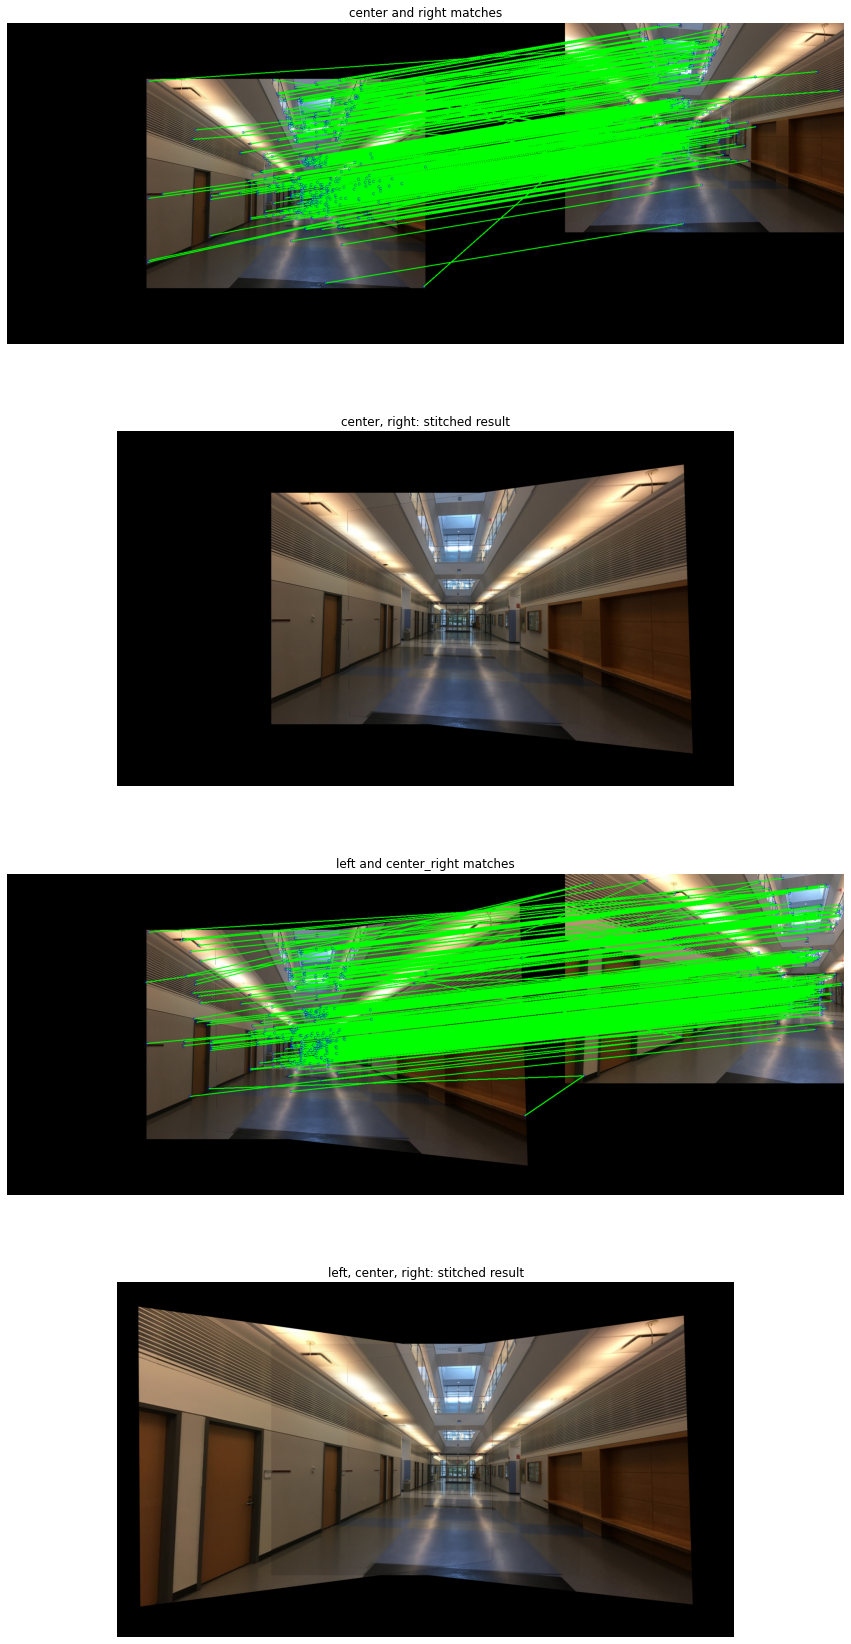

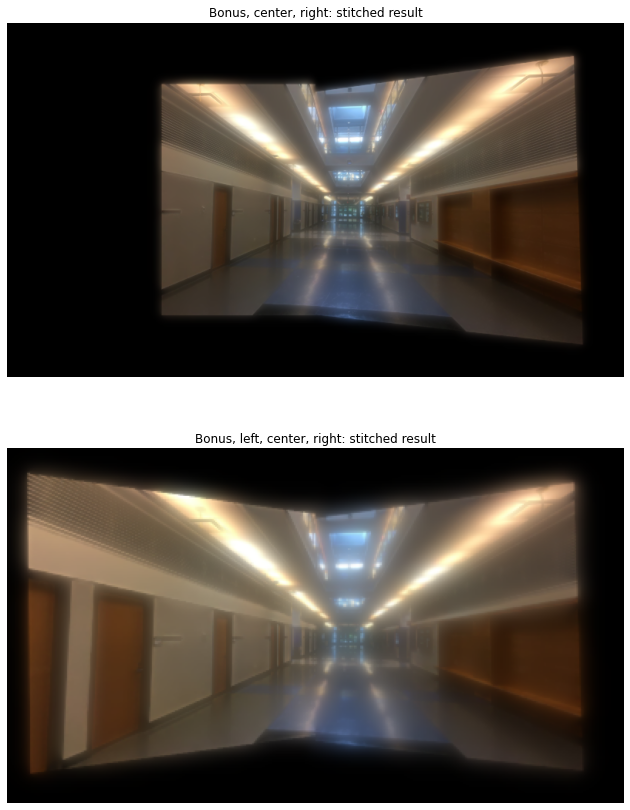

In [ ]:
imgCenter = cv2.imread('/content/gdrive/MyDrive/CVHomework2/SourceImages/cs_m.jpg', cv2.IMREAD_COLOR)
imgRight  = cv2.imread('/content/gdrive/MyDrive/CVHomework2/SourceImages/cs_r.jpg', cv2.IMREAD_COLOR)
imgLeft   = cv2.imread('/content/gdrive/MyDrive/CVHomework2/SourceImages/cs_l.jpg', cv2.IMREAD_COLOR)

# initalize the stitched image as the center image
# the following is recommended padding size, DO NOT change it 
imgCenter = cv2.copyMakeBorder(imgCenter,160,160,400,400,cv2.BORDER_CONSTANT)

def alpha_blending(img_A, img_B):    
    # Implement alpha_blending, using 0.5 and 0.5 for alphas
    #print(img_A.shape,img_B.shape)
    #blended = cv2.addWeighted(img_A,0.5,img_B,0.5,0)
    blended = img_A.copy()
    alpharow,alphacol = img_A.shape[:2]

    for ek in range(3):
      for be in range(alpharow):
        for tran in range(alphacol):
          if (img_A[be,tran,ek] > 0 and img_B[be,tran,ek] > 0):
            alpha = 0.5
          elif (img_A[be,tran,ek] > 0):
            alpha = 1
          else :
            alpha = 0

          blended[be,tran,ek] = alpha* img_A[be,tran,ek] + (1-alpha) * img_B[be,tran,ek] 
    return blended
    

def Laplacian_blending(img_A, img_B, num_levels=4, mask=None):
    # Implement Laplacian_blending
    # num_levels is the number of levels in the pyramids
    # assume mask is float32 [0,1], it has the same size as img_A and img_B
    # the mask indicates which parts of img_A or img_B are blended together
    # a simple example could be  
    # mask = np.hstack([np.zeros([img_A.shape[0],img_A.shape[1]//2,img_A.shape[2]], np.float32),
    #  np.ones([img_B.shape[0],img_B.shape[1]//2,img_B.shape[2]], np.float32)])
    # but it depends on your choice
    # you may even skip this parameter if you always use one-half 0s and one-half 1s like the tutorial
    
    #assert img_A.shape == mask.shape
    assert img_A.shape == img_B.shape
    # generate Gaussian pyramids for img_A, img_B and corresponding masks   
    pyramid_imgA = img_A.copy()
    gp_imgA = [pyramid_imgA]
    for i in range(num_levels):
      pyramid_imgA = cv2.pyrDown(pyramid_imgA)
      gp_imgA.append(pyramid_imgA)
    
    pyramid_imgB = img_B.copy()
    gp_imgB = [pyramid_imgB]
    for i in range(num_levels):
      pyramid_imgB = cv2.pyrDown(pyramid_imgB)
      gp_imgB.append(pyramid_imgB)

      
    # generate Laplacian pyramids for img_A, img_B and corresponding masks 
    lp_imgA = [gp_imgA[num_levels]]
    for i in range(num_levels,0, -1):
      lp_pyramid_imgA = cv2.pyrUp(gp_imgA[i], dstsize = (gp_imgA[i - 1].shape[1], gp_imgA[i - 1].shape[0]))
      lp_imgA.append(cv2.subtract(gp_imgA[i-1], lp_pyramid_imgA))

    lp_imgB = [gp_imgB[num_levels]]
    for i in range(num_levels,0, -1):
      lp_pyramid_imgB = cv2.pyrUp(gp_imgB[i], dstsize = (gp_imgB[i - 1].shape[1], gp_imgB[i - 1].shape[0]))
      lp_imgB.append(cv2.subtract(gp_imgB[i-1], lp_pyramid_imgB))

    
    # now blend images with your mask in each level
    maskappend = []
    for p,q in zip(lp_imgA,lp_imgB):
      r,c,depth = p.shape
      letc = np.hstack((p[:,0:c//2], q[:,c//2:]))
      maskappend.append(letc)

    # now reconstruct the blended image
    leti = maskappend[0]
    for o in range(1,num_levels):
      leti = cv2.pyrUp(leti)
      leti = np.resize(leti, maskappend[o].shape)
      leti = cv2.add(leti, maskappend[o])
    
    blended = leti
    return blended

def getTransform(img1, img2):
    # compute sift descriptors
    # initiate SIFT detector
    my_1sift = cv2.xfeatures2d.SIFT_create()
    my_2sift = cv2.xfeatures2d.SIFT_create()

    # find the keypoints and descriptors with SIFT
    mykp1, mydes1 = my_1sift.detectAndCompute(img1, None)
    mykp2, mydes2 = my_2sift.detectAndCompute(img2, None)

    # find all matches
      # for feature match, i used the knnMatch function from cv2.BFMatcher 
    mybf = cv2.BFMatcher()
    mymatches = mybf.knnMatch(mydes2, mydes1 , k = 2)

    # apply ratio test, use ratio = 0.75
    my_good_matches = []
    for m, n in mymatches :
      if m.distance < 0.75*n.distance :
        my_good_matches.append(m)
        
    # draw matches
    img_match = drawMatches(img2, mykp2, img1, mykp1, my_good_matches)

    # find perspective transform matrix using RANSAC
    my_source_points = np.float32([mykp1[m.trainIdx].pt for m in my_good_matches]).reshape(-1, 1, 2)
    my_dest_points = np.float32([mykp2[m.queryIdx].pt for m in my_good_matches]).reshape(-1, 1, 2)
    H, retval =  cv2.findHomography(my_source_points, my_dest_points, cv2.RANSAC, 5.0)
    # H is the perspective transform matrix
    # img_match is the image returned by drawMatches
    return H, img_match

def perspective_warping_alpha_blending(imgCenter, imgLeft, imgRight):
    # Get homography from right to center
    # img_match_cr is your first output
    # call getTransform to get the transformation from the right to the center image
    hcr , img_match_cr = getTransform(imgRight, imgCenter)
    imgRight_warped = cv2.warpPerspective(imgRight, hcr, (imgCenter.shape[1],imgCenter.shape[0]))

    
    # Blend center and right
    # stitched_cr is your second output, returned by alpha_blending 
    # call alpha_blending
    stitched_cr = alpha_blending(imgCenter, imgRight_warped)
    
    # Get homography from left to stitched center_right
    # img_match_lcr is your third output
    # call getTransform to get the transformation from the left to stitched_cr
    hlcr, img_match_lcr = getTransform(imgLeft, stitched_cr)
    imgLeft_warped = cv2.warpPerspective(imgLeft, hlcr, (stitched_cr.shape[1],stitched_cr.shape[0]))

    # Blend left and center_right
    # stitched_lcr is your fourth output, returned by alpha_blending  
    # call alpha_blending
    stitched_lcr = alpha_blending(imgLeft_warped, stitched_cr)
    return img_match_cr, stitched_cr, img_match_lcr, stitched_lcr 

def perspective_warping_laplacian_blending(imgCenter, imgLeft, imgRight):
    # Get homography from right to center
    # call getTransform to get the transformation from the right to the center image
    hcr , img_match_cr = getTransform(imgRight, imgCenter)

    my_rightwarp_image = cv2.warpPerspective(imgRight, hcr, (imgCenter.shape[1],imgCenter.shape[0]))
    
    # Blend center and right
    # stitched_cr is your first bonus output, returned by Laplacian_blending 
    # call Laplacian_blending 
    stitched_cr = Laplacian_blending(imgCenter, my_rightwarp_image)
    
    # Get homography from left to stitched center_right
    # call getTransform to get the transformation from the left to stitched_cr
    hlcr, img_match_lcr = getTransform(imgLeft, stitched_cr)
    my_leftwarp_image = cv2.warpPerspective(imgLeft, hlcr, (stitched_cr.shape[1],stitched_cr.shape[0]))
    
    
    # Blend left and center_right
    # stitched_lcr is your second bonus output, returned by Laplacian_blending
    # call Laplacian_blending
    stitched_lcr = Laplacian_blending(my_leftwarp_image, stitched_cr)
    return img_match_cr, stitched_cr, img_match_lcr, stitched_lcr 


img_match_cr, stitched_cr, img_match_lcr, stitched_lcr = perspective_warping_alpha_blending(imgCenter, imgLeft, imgRight)
img_match_cr_lap, stitched_cr_lap, img_match_lcr_lap, stitched_lcr_lap = perspective_warping_laplacian_blending(imgCenter, imgLeft, imgRight)
        
plt.figure(figsize=(15,30));
plt.subplot(4, 1, 1);
plt.imshow(cv2.cvtColor(img_match_cr, cv2.COLOR_BGR2RGB));
plt.title("center and right matches");
plt.axis('off');
plt.subplot(4, 1, 2);
plt.imshow(cv2.cvtColor(stitched_cr, cv2.COLOR_BGR2RGB));
plt.title("center, right: stitched result");
plt.axis('off');
plt.subplot(4, 1, 3);
plt.imshow(cv2.cvtColor(img_match_lcr, cv2.COLOR_BGR2RGB));
plt.title("left and center_right matches");
plt.axis('off');
plt.subplot(4, 1, 4);
plt.imshow(cv2.cvtColor(stitched_lcr, cv2.COLOR_BGR2RGB));
plt.title("left, center, right: stitched result");
plt.axis('off');
plt.show();

plt.figure(figsize=(15,30));
plt.subplot(4, 1, 1);
plt.imshow(cv2.cvtColor(stitched_cr_lap, cv2.COLOR_BGR2RGB));
plt.title("Bonus, center, right: stitched result");
plt.axis('off');
plt.subplot(4, 1, 2);
plt.imshow(cv2.cvtColor(stitched_lcr_lap, cv2.COLOR_BGR2RGB));
plt.title("Bonus, left, center, right: stitched result");
plt.axis('off');


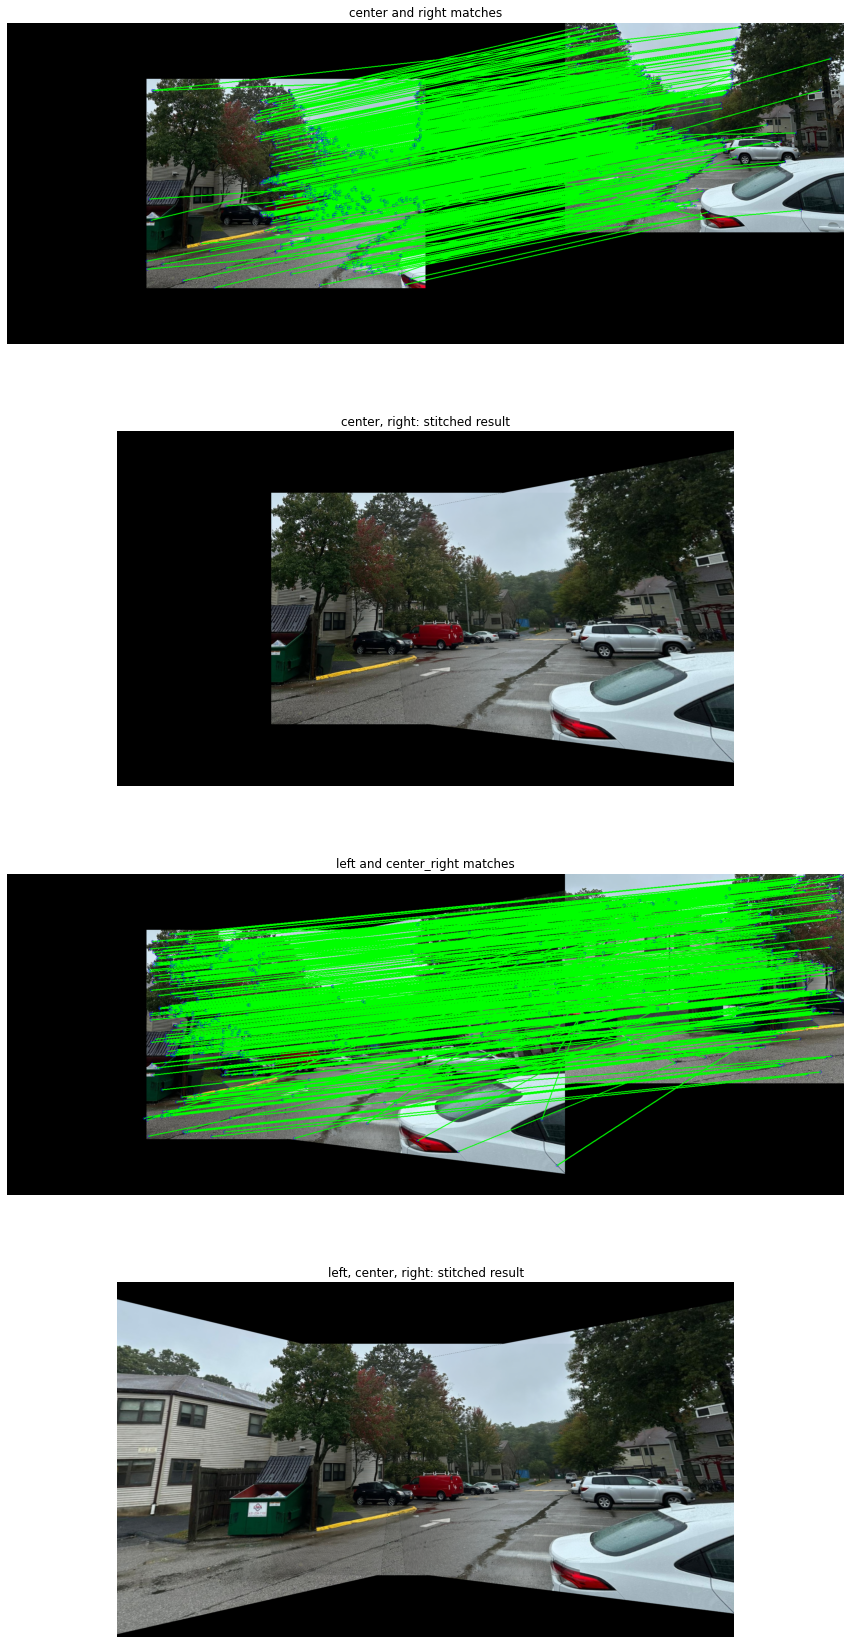

In [ ]:
bonus_imgCenter = cv2.imread('/content/gdrive/MyDrive/CVHomework2/SourceImages/bonuscentre.png', cv2.IMREAD_COLOR)
bonus_imgRight  = cv2.imread('/content/gdrive/MyDrive/CVHomework2/SourceImages/bonusright.png', cv2.IMREAD_COLOR)
bonus_imgLeft   = cv2.imread('/content/gdrive/MyDrive/CVHomework2/SourceImages/bonusleft.png', cv2.IMREAD_COLOR)


bonus_imgCenter = cv2.copyMakeBorder(bonus_imgCenter,160,160,400,400,cv2.BORDER_CONSTANT)

bonus_img_match_cr, bonus_stitched_cr, bonus_img_match_lcr, bonus_stitched_lcr = perspective_warping_alpha_blending(bonus_imgCenter, bonus_imgLeft, bonus_imgRight)
        
plt.figure(figsize=(15,30));
plt.subplot(4, 1, 1);
plt.imshow(cv2.cvtColor(bonus_img_match_cr, cv2.COLOR_BGR2RGB));
plt.title("center and right matches");
plt.axis('off');
plt.subplot(4, 1, 2);
plt.imshow(cv2.cvtColor(bonus_stitched_cr, cv2.COLOR_BGR2RGB));
plt.title("center, right: stitched result");
plt.axis('off');
plt.subplot(4, 1, 3);
plt.imshow(cv2.cvtColor(bonus_img_match_lcr, cv2.COLOR_BGR2RGB));
plt.title("left and center_right matches");
plt.axis('off');
plt.subplot(4, 1, 4);
plt.imshow(cv2.cvtColor(bonus_stitched_lcr, cv2.COLOR_BGR2RGB));
plt.title("left, center, right: stitched result");
plt.axis('off');
plt.show();

## Problem 3: Object Recognition with HOG features
{30 points} You will use the histogram of oriented gradients (HOG) to extract features from objects and recognize them.

HOG decomposes an image into multiple cells, computes the direction of the gradients for all pixels in each cell, and creates a histogram of gradient orientation for that cell. Object recognition with HOG is usually done by extracting HOG features from a training set of images, learning a support vector machine (SVM) from those features, and then testing a new image with the SVM to determine the existence of an object.

You can use `cv2.ml.SVM_create` for SVMs. You can also use Python machine learning packages for SVM, e.g.`scikit-learn` and for HoG computation, e.g. `scikit-image`. Please find the OpenCV SVM tutorial at https://www.learnopencv.com/handwritten-digits-classification-an-opencv-c-python-tutorial/.

An image set located under SourceImages/ETH-80 is provided containing images of two class: **apple** and **pear**. You will first train an SVM with the HoG features and then predict the class of an image with the trained SVM. The images have been split into training set (folder 1) and test set (folder 2).

Some of the function names and arguments are provided, you may change them as you need.

- **Step 1 (5pts)**. Load in the images and create a vector of corresponding labels (0 for apple and 1 for pear). An example label vector should be something like [1,1,1,1,1,0,0,0,0,0]. Display any six apple images and any six pear images of **training set** in a 2 x 6 grid with figsize = (20, 5).

- **Step 2 (10pts)**. Extract HoG features from all images. You can use hog routine from `scikit-image`. Display the HoG features for the six apple images and six pear images **chosen in step 1** in a 2 x 6 grid with figsize = (20, 5).

- **Step 3**. Shuffle your training date including features and labels. Reshape the HoG feature matrix as necessary to feed into the SVM. Train the classifier. **DO NOT train with test data.** No output is expected from this part.

- **Step 4 (15pts)**. Perform predictions with your trained SVM on the test data. Output a vector of predictions, a vector of ground truth labels, and prediction accuracy.

[reference of ETH-80 dataset] B. Leibe and, B.Schiele. Analyzing Appearance and Contour Based Methods for Object Categorization. CVPR, vol.2, pp. 409-415, 2003

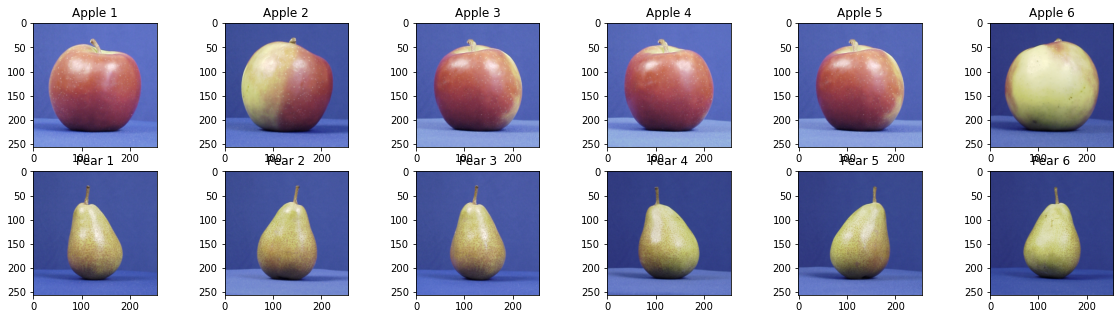

In [ ]:
import skimage.exposure
from skimage.feature import hog
from sklearn.svm import LinearSVC

def loadData(path):
  # you can use sorted(os.listdir(path)) to get all files under a directory
  get_images = sorted(os.listdir(path))
  img = []
  for x in get_images:
    img.append(cv2.imread(path + '/' + x, cv2.IMREAD_COLOR))

  return img

imgs_train_0 = loadData('/content/gdrive/MyDrive/CVHomework2/SourceImages/ETH-80/apple/1')
imgs_train_1 = loadData('/content/gdrive/MyDrive/CVHomework2/SourceImages/ETH-80/pear/1')
imgs_test_0 = loadData('/content/gdrive/MyDrive/CVHomework2/SourceImages/ETH-80/apple/2')
imgs_test_1 = loadData('/content/gdrive/MyDrive/CVHomework2/SourceImages/ETH-80/pear/2')

# combine class 0 with class 1
imgs_train = imgs_train_1 + imgs_train_0
imgs_test = imgs_test_0 + imgs_test_1

# create class labels, assume apple = 0, pear = 1
labels_train = np.concatenate((np.ones(len(imgs_train_1)),np.zeros(len(imgs_train_0))), axis = None)
labels_test = np.concatenate((np.zeros(len(imgs_test_0)) , np.ones(len(imgs_test_1))), axis = None)

# display ANY 6 apple images and 6 pear images of TRAINING set 
# in a 2 x 6 grid with figsize = (20, 5)

my_apples = []       
for a in range(len(labels_train)):
  if labels_train[a] == 0:
    my_apples.append(a)
my_apples_updated = np.random.choice(my_apples,6)

apple_list = []
for b in my_apples_updated:
  apple_list.append(imgs_train[b])

my_pears = [] 
for c in range(len(labels_train)):
  if labels_train[c] == 1:
    my_pears.append(c)
my_pears_updated = np.random.choice(my_pears,6)

pear_list = []
for d in my_pears_updated:
  pear_list.append(imgs_train[d])

plt.figure(figsize=(20,5));

for e in range(6):
  plt.subplot(2,6,e+1);
  plt.imshow(cv2.cvtColor(apple_list[e], cv2.COLOR_BGR2RGB));
  plt.title('Apple ' + str(e+1))


for f in range(6):
  plt.subplot(2,6,f+7);
  plt.imshow(cv2.cvtColor(pear_list[f], cv2.COLOR_BGR2RGB));
  plt.title('Pear ' + str(f+1))

plt.show()

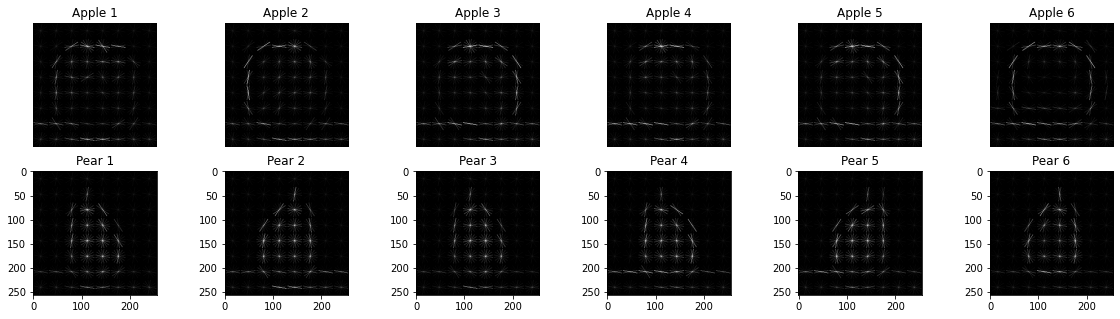

In [ ]:
# Compute HOG features for the images
def computeHOGfeatures(image):
    # Compute HOG descriptors of a single image
    # you can use skimage.feature.hog and try your own parameters

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_descriptor, hog_image = hog(gray_image, orientations=8, pixels_per_cell=(32, 32), cells_per_block=(1, 1), visualize=True)
    hog_image = skimage.exposure.rescale_intensity(hog_image, in_range=(0, 7))
 
    return hog_descriptor, hog_image

def computeHOGfeaturesBatch(imgs):
    # Compute HOG descriptors of a batch of images

    hog_descriptors = []
    hog_images = []
    for g in imgs:
      hog_descriptor, hog_image = computeHOGfeatures(g)
      hog_descriptors.append(hog_descriptor)
      hog_images.append(hog_image)

    return hog_descriptors, hog_images
  

my_train_hogs, my_train_hogs_images = computeHOGfeaturesBatch(imgs_train)
Hogs_test, Hog_imgs_test = computeHOGfeaturesBatch(imgs_test)


# display hog images CORRESPONDING to the 4 apple and 4 pear images you chosed in previous step
# in a 2 x 4 grid with figsize = (20, 5)

plt.figure(figsize=(20,5));
apples_hog_descriptors ,apples_hog_images = computeHOGfeaturesBatch(apple_list)
pears_hog_descriptors ,pears_hog_images = computeHOGfeaturesBatch(pear_list)

for h in range(6):
  plt.subplot(2,6,h+1);
  plt.imshow(apples_hog_images[h],'gray');
  plt.title('Apple ' + str(h+1))
  plt.axis('off')

for k in range(6):
  plt.subplot(2,6,k+7);
  plt.imshow(pears_hog_images[k], 'gray');
  plt.title('Pear ' + str(k+1))

plt.show()

In [ ]:
import random

# create a svm model
svm_model = cv2.ml.SVM_create()
svm_model.setType(cv2.ml.SVM_C_SVC)
svm_model.setKernel(cv2.ml.SVM_RBF)

#setting my own hyper-parameters
svm_model.setC(18.9)
svm_model.setGamma(1.302)

# shuffle training data
svm_labels_train = labels_train
svm_hogs_train = my_train_hogs
svm_hogs_train_zip = list(zip(svm_hogs_train, svm_labels_train))
random.shuffle(svm_hogs_train_zip)
svm_hogs_train, svm_labels_train = zip(*svm_hogs_train_zip)

# train svm with training data
svm_hogs_train = np.float32(svm_hogs_train)
svm_labels_train = np.asarray(svm_labels_train, dtype= np.int32)
svm_model.train(svm_hogs_train, cv2.ml.ROW_SAMPLE, svm_labels_train)

# make predictions on test data
Hogs_test = np.float32(Hogs_test)
labels_test_pred = svm_model.predict(Hogs_test)[1].ravel()

# print predictions and accuracy
print('Predicted labels: ', labels_test_pred.astype(np.int8).reshape([-1]))
print('Ground truth labels: ', labels_test.astype(np.int8).reshape([-1]))
print('Accuracy: ', np.mean(labels_test_pred.astype(np.int8)==labels_test.astype(np.int8))*100, '%')

Predicted labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
Ground truth labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Accuracy:  96.875 %
